# Compare distribution of posts across groups over time
In which we determine whether there is significant variation in post volume across groups over time.

In [5]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from dateutil import parser

## Load data

In [7]:
fb_data = pd.read_csv('../../data/facebook-maria/combined_group_data.tsv', sep='\t', index_col=False, encoding='utf-8')
# parse dates
fb_data.loc[:, 'status_published'] = fb_data.loc[:, 'status_published'].apply(lambda x: parser.parse(x))
fb_data.head()

,group_id,status_author_id,status_message,status_lang,status_id,status_published
0,351272391991842,10159623474155515,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23
1,351272391991842,10155877836122783,Para alguien que lo necesite... Dale Share..A ...,es,351272391991842_361695457616202,2017-10-18 06:47:34
2,351272391991842,10215020607489848,One unsafe well in Dorado on Carr 694 km 4.5,en,351272391991842_361487960970285,2017-10-17 20:20:03
3,351272391991842,1716175958400853,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08
4,351272391991842,141039043205101,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22


In [8]:
group_loc_data = pd.read_csv('../../data/facebook-maria/location_group_data.tsv', sep='\t', index_col=False, encoding='utf-8')
group_loc_data.head()

,location_name,group_id,group_name
0,Aguada,1724474021195839,Huracan Maria Anasco y Aguada
1,Aguadilla,117529462276443,Huracan Maria Aguadilla
2,Aguadilla,1390525734396603,Huracan Maria - Aguadilla - Ceiba Baja y Guerrero
3,Aguas Buenas,1723084327997466,Aguas Buenas Huracan Maria
4,Aguas Buenas,210130182858104,"Huracán María Comerío Bayamón Aguas Buenas, ar..."


In [9]:
# join data
fb_data = pd.merge(fb_data, group_loc_data.loc[:, ['location_name', 'group_id']], on='group_id', how='outer')

## Per-group counts
Just to remind me: how many statuses per group?

In [10]:
group_counts = fb_data.loc[:, 'group_id'].value_counts()
print(group_counts)

1773209126315380    4568
132392547395104     3016
127217134598253     2874
891721064308258     2124
119087272129297     1679
1979604895658060    1666
130913387550000     1221
117445378946554     1101
132963337341347     1084
228066954387757      962
721270821393500      913
1972572999632293     884
132022090761950      878
239379013253824      754
1815374475420954     718
1724474021195839     688
1723084327997466     536
311739902631820      531
118787682128186      487
1909452959306518     469
1306772706118778     427
844368579056187      424
486819048360070      397
142680509678003      381
1988415758095382     340
320205998443003      331
185336475344755      318
505778186467207      235
119132632075224      215
889808494515226      148
                    ... 
351272391991842      103
1453581968094172      99
128909594424200       93
1732562527048857      87
239708553223790       87
803659183149847       85
210130182858104       80
1961676614046008      76
1103661653103604      67


In [11]:
# same thing but location
loc_counts = fb_data.loc[:, 'location_name'].value_counts()
loc_counts

Guayama          4568
Vega Alta        3016
Coamo            2888
Barranquitas     2874
Quebradillas     2019
Corozal          1671
Yabucoa          1572
Vega Baja        1425
Patillas         1389
Ponce            1316
Cidra            1187
Utuado           1101
Cayey            1084
Lajas             878
San Germán        659
Aguas Buenas      556
Arroyo            487
Mayagüez          403
Naranjito         397
Aguada            344
Añasco            344
Dorado            283
Isabela           215
Trujillo Alto     148
Orocovis          134
Juana Díaz        122
Toa Alta           99
Canóvanas          87
San Lorenzo        85
Bayamón            84
Lares              76
Manatí             68
Cataño             46
Naguabo            39
Aguadilla          37
Maricao            33
Ceiba              22
Comerío            20
Juncos             18
Caguas             18
Humacao            18
Maunabo             6
Vieques             2
Gurabo              2
Guánica             1
Yauco     

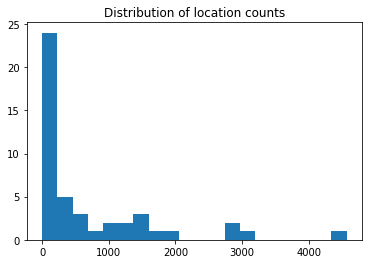

In [34]:
plt.hist(loc_counts, bins=20)
plt.title("Distribution of location counts")
plt.show()

Just as I thought: a few groups with a lot of posts, followed by a long tail of less popular groups.

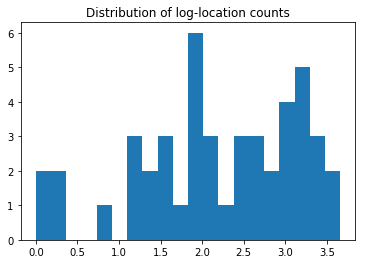

In [36]:
# maybe log-counts looks better
log_loc_counts = pd.np.log10(loc_counts)
plt.hist(log_loc_counts, bins=20)
plt.title("Distribution of log-location counts")
plt.show()

If we were going to cut this group into high/medium/low posts, what would be the best split points?

Let's look at a kernel density estimate to figure this out.

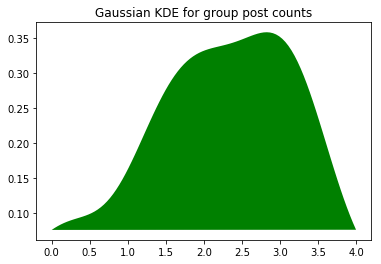

In [62]:
import numpy as np
from sklearn.neighbors import KernelDensity
N = len(log_loc_counts.values)
X = np.reshape(log_loc_counts.values, (N,1))
bandwidth = .45
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
X_min = 0
X_max = 4
X_samples = 100
X_plot = np.linspace(X_min, X_max, X_samples)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.fill(X_plot[:, 0], np.exp(log_dens), fc='green')
plt.title('Gaussian KDE for group post counts')
plt.show()

Not great! There are no obvious splits in the data between low, medium and high-posting groups.

What if we just try splitting the cumulative percent into three bins with equal size in terms of post count?

In [83]:
# cumulative sum
cumulative_pct = loc_counts.cumsum() / loc_counts.sum()
cumulative_pct

Guayama          0.143458
Vega Alta        0.238176
Coamo            0.328874
Barranquitas     0.419132
Quebradillas     0.482539
Corozal          0.535017
Yabucoa          0.584385
Vega Baja        0.629138
Patillas         0.672759
Ponce            0.714088
Cidra            0.751366
Utuado           0.785943
Cayey            0.819986
Lajas            0.847560
San Germán       0.868256
Aguas Buenas     0.885717
Arroyo           0.901011
Mayagüez         0.913667
Naranjito        0.926135
Aguada           0.936939
Añasco           0.947742
Dorado           0.956630
Isabela          0.963382
Trujillo Alto    0.968030
Orocovis         0.972238
Juana Díaz       0.976069
Toa Alta         0.979178
Canóvanas        0.981911
San Lorenzo      0.984580
Bayamón          0.987218
Lares            0.989605
Manatí           0.991740
Cataño           0.993185
Naguabo          0.994410
Aguadilla        0.995572
Maricao          0.996608
Ceiba            0.997299
Comerío          0.997927
Juncos      

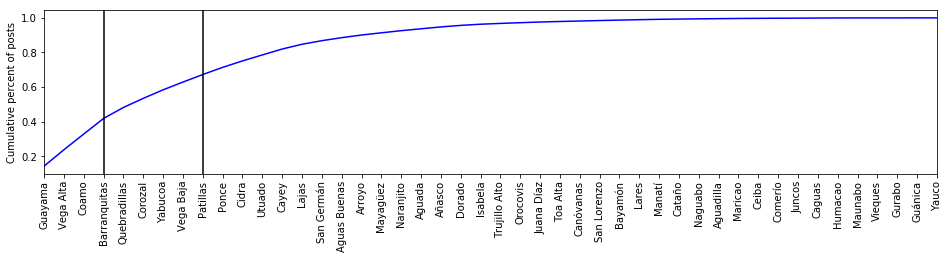

In [87]:
G = len(cumulative_pct)
X_pos = range(1, len(cumulative_pct)+1)
X_tick_labels = cumulative_pct.index.tolist()
plt.figure(figsize=(16, 3))
plt.plot(X_pos, cumulative_pct, 'b-')
plt.xticks(X_pos, X_tick_labels, rotation=90)
plt.ylabel('Cumulative percent of posts')
# add vlines at split points
splits = 3
split_pcts = np.linspace(1./splits, 1., splits)[:-1]
for s in split_pcts:
    split_point = np.where(cumulative_pct > s)[0][1]
    plt.axvline(split_point, color='k')
plt.xlim(1, G)
plt.show()

OK! It looks like the following group divisions are made:

- high = `Guayama` - `Coamo`
- med = `Barranquitas` - `Vega Baja`
- low = `Patillas` - `Yauco`



Let's check if this still holds when we look at only Spanish posts.

In [91]:
fb_data_es = fb_data[fb_data.loc[:, 'status_lang'] == 'es']
print('%d/%d posts in Spanish'%(fb_data_es.shape[0], fb_data.shape[0]))

23852/31842 posts in Spanish


Guayama          0.156758
Vega Alta        0.257127
Barranquitas     0.347644
Coamo            0.434932
Quebradillas     0.494759
Corozal          0.549094
Yabucoa          0.598943
Vega Baja        0.642671
Patillas         0.685813
Ponce            0.727067
Cidra            0.763919
Utuado           0.799304
Cayey            0.832677
Lajas            0.857245
San Germán       0.878752
Aguas Buenas     0.898248
Arroyo           0.913676
Naranjito        0.927008
Mayagüez         0.938831
Dorado           0.947216
Aguada           0.953840
Añasco           0.960465
Isabela          0.966837
Trujillo Alto    0.971617
Orocovis         0.975641
Juana Díaz       0.979499
Toa Alta         0.982098
Manatí           0.984488
Bayamón          0.986877
Lares            0.989267
San Lorenzo      0.991280
Canóvanas        0.992998
Cataño           0.994298
Naguabo          0.995556
Maricao          0.996604
Juncos           0.997359
Caguas           0.998030
Humacao          0.998575
Aguadilla   

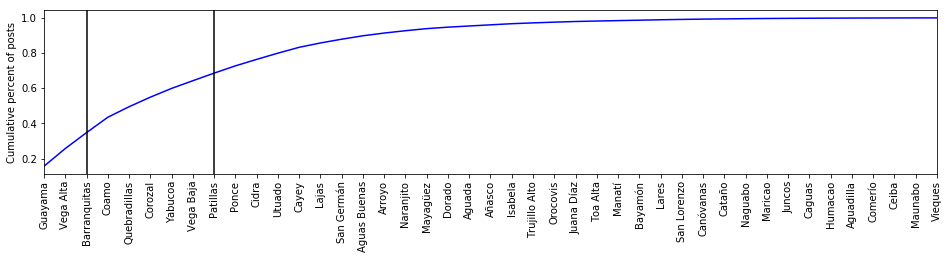

In [93]:
loc_counts_es = fb_data_es.loc[:, 'location_name'].value_counts()
cumulative_pct_es = loc_counts_es.cumsum() / loc_counts_es.sum()
print(cumulative_pct_es)
G = len(cumulative_pct_es)
X_pos = range(1, len(cumulative_pct_es)+1)
X_tick_labels = cumulative_pct_es.index.tolist()
plt.figure(figsize=(16, 3))
plt.plot(X_pos, cumulative_pct_es, 'b-')
plt.xticks(X_pos, X_tick_labels, rotation=90)
plt.ylabel('Cumulative percent of posts')
# add vlines at split points
splits = 3
split_pcts = np.linspace(1./splits, 1., splits)[:-1]
for s in split_pcts:
    split_point = np.where(cumulative_pct_es > s)[0][1]
    plt.axvline(split_point, color='k')
plt.xlim(1, G)
plt.show()

A slightly different breakdown of posts! Looks like the following groups will have to do:

- High = `Guayama`, `Vega Alta`
- Medium = `Barranquitas` ... `Vega Baja`
- Low = `Patillas` ... `Vieques`

## Distribution over time
Now let's look at the post distribution over time to determine the best periods for initial, short-term and long-term time frames.

First we need to bin the data by time (1-minute intervals?) so that we can plot it like a regular time series.

In [117]:
test_time = fb_data_es.loc[:, 'status_published'][0]
print(test_time)
test_time = test_time.round('min')
print(test_time)
# test_time = pd.Timestamp(((test_time.asm8/(1e9*60)).round()*1e9*60).astype(np.int64))
# print(test_time)

2017-10-19 18:25:23
2017-10-19 18:25:00


In [118]:
round_to_min = lambda x: x.round('min')
fb_data_es.loc[:, 'status_published_min'] = fb_data_es.loc[:, 'status_published'].apply(round_to_min)

/hg190/istewart6/crisis_language/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/crisis_language/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [119]:
time_counts = fb_data_es.loc[:, 'status_published_min'].value_counts()
time_counts = time_counts.loc[time_counts.index.sort_values()]
time_cumulative_pcts = time_counts.cumsum() / time_counts.sum()
print(time_cumulative_pcts.head())

2017-09-20 16:17:00    0.000042
2017-09-20 16:18:00    0.000126
2017-09-20 16:22:00    0.000168
2017-09-20 16:29:00    0.000210
2017-09-20 16:33:00    0.000252
Name: status_published_min, dtype: float64


In [129]:
time_cumulative_pcts.tail()

2017-10-19 18:02:00    0.999790
2017-10-19 18:09:00    0.999832
2017-10-19 18:22:00    0.999874
2017-10-19 18:23:00    0.999958
2017-10-19 18:25:00    1.000000
Name: status_published_min, dtype: float64

We have to generate the full time series from start to finish, with 1-minute intervals, in order to ensure a consistent series.

In [130]:
start_time = fb_data_es.loc[:, 'status_published_min'].min()
end_time = fb_data_es.loc[:, 'status_published_min'].max()
time_full = pd.date_range(start_time, end_time, freq='min')
# start with empty time series, then fill with cumulative percents
time_full_pcts = pd.Series(pd.np.zeros(len(time_full)), index=time_full)
time_full_pcts.loc[time_cumulative_pcts.index] = time_cumulative_pcts.values
# fill up the zeroes
time_full_pcts = time_full_pcts.replace(to_replace=0, method='ffill')
print(time_full_pcts.head(20))
print(time_full_pcts.tail(20))

2017-09-20 16:17:00    0.000042
2017-09-20 16:18:00    0.000126
2017-09-20 16:19:00    0.000126
2017-09-20 16:20:00    0.000126
2017-09-20 16:21:00    0.000126
2017-09-20 16:22:00    0.000168
2017-09-20 16:23:00    0.000168
2017-09-20 16:24:00    0.000168
2017-09-20 16:25:00    0.000168
2017-09-20 16:26:00    0.000168
2017-09-20 16:27:00    0.000168
2017-09-20 16:28:00    0.000168
2017-09-20 16:29:00    0.000210
2017-09-20 16:30:00    0.000210
2017-09-20 16:31:00    0.000210
2017-09-20 16:32:00    0.000210
2017-09-20 16:33:00    0.000252
2017-09-20 16:34:00    0.000252
2017-09-20 16:35:00    0.000252
2017-09-20 16:36:00    0.000252
Freq: T, dtype: float64
2017-10-19 18:06:00    0.999790
2017-10-19 18:07:00    0.999790
2017-10-19 18:08:00    0.999790
2017-10-19 18:09:00    0.999832
2017-10-19 18:10:00    0.999832
2017-10-19 18:11:00    0.999832
2017-10-19 18:12:00    0.999832
2017-10-19 18:13:00    0.999832
2017-10-19 18:14:00    0.999832
2017-10-19 18:15:00    0.999832
2017-10-19 18:16

Great. Now it's time to plot.

2017-09-22 22:56:00
2017-09-26 19:38:00


/hg190/istewart6/crisis_language/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  
/hg190/istewart6/crisis_language/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  from ipykernel import kernelapp as app
/hg190/istewart6/crisis_language/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()


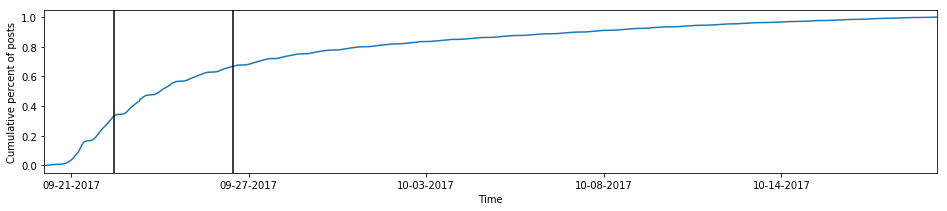

In [198]:
plt.figure(figsize=(16,3))
plt.plot(time_full_pcts.index, time_full_pcts)
plt.xlabel('Time')
plt.ylabel('Cumulative percent of posts')
# change x ticks to dates
x_ticks = plt.xticks()[0]
date_fmt = '%m-%d-%Y'
x_tick_timestamps = map(pd.Timestamp, x_ticks)
x_tick_timestamps = map(lambda x: x.strftime(date_fmt), x_tick_timestamps)
plt.xticks(x_ticks, x_tick_timestamps)
# set x lim
START = datetime(1970,1,1)
convert_time = lambda x: (x.to_datetime() - START).total_seconds() * 1e9
x_min = convert_time(time_full_pcts.index[0])
x_max = convert_time(time_full_pcts.index[-1])
plt.xlim(x_min, x_max)
# set vlines at 1/3 time marks
splits = 3
split_pcts = np.linspace(1. / splits, 1., splits)[:-1]
for s in split_pcts:
    cutoff_date = time_full_pcts.index[np.where(time_full_pcts > s)[0][1]]
    print(cutoff_date)
    cutoff = convert_time(cutoff_date)
    plt.axvline(cutoff, color='k')
plt.show()

Most posts happened within the first few days, which makes sense in the disaster-relief setting: you want information really soon after impact, with less demand in the following weeks.

Sanity check: is this time pattern consistent across location groups?

In [199]:
fb_data_es.head()

,group_id,status_author_id,status_message,status_lang,status_id,status_published,location_name,status_published_min
0,351272391991842,1.015962e+16,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23,Dorado,2017-10-19 18:25:00
1,351272391991842,1.015588e+16,Para alguien que lo necesite... Dale Share..A ...,es,351272391991842_361695457616202,2017-10-18 06:47:34,Dorado,2017-10-18 06:48:00
3,351272391991842,1.716176e+15,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08,Dorado,2017-10-17 17:38:00
4,351272391991842,1.410390e+14,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22,Dorado,2017-10-11 14:14:00
5,351272391991842,1.410390e+14,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,es,351272391991842_358942134558201,2017-10-11 14:37:12,Dorado,2017-10-11 14:37:00


In [215]:
x_tick_timestamps

['09-20-2017',
 '09-26-2017',
 '10-02-2017',
 '10-08-2017',
 '10-13-2017',
 '10-19-2017']

/hg190/istewart6/crisis_language/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  del sys.path[0]


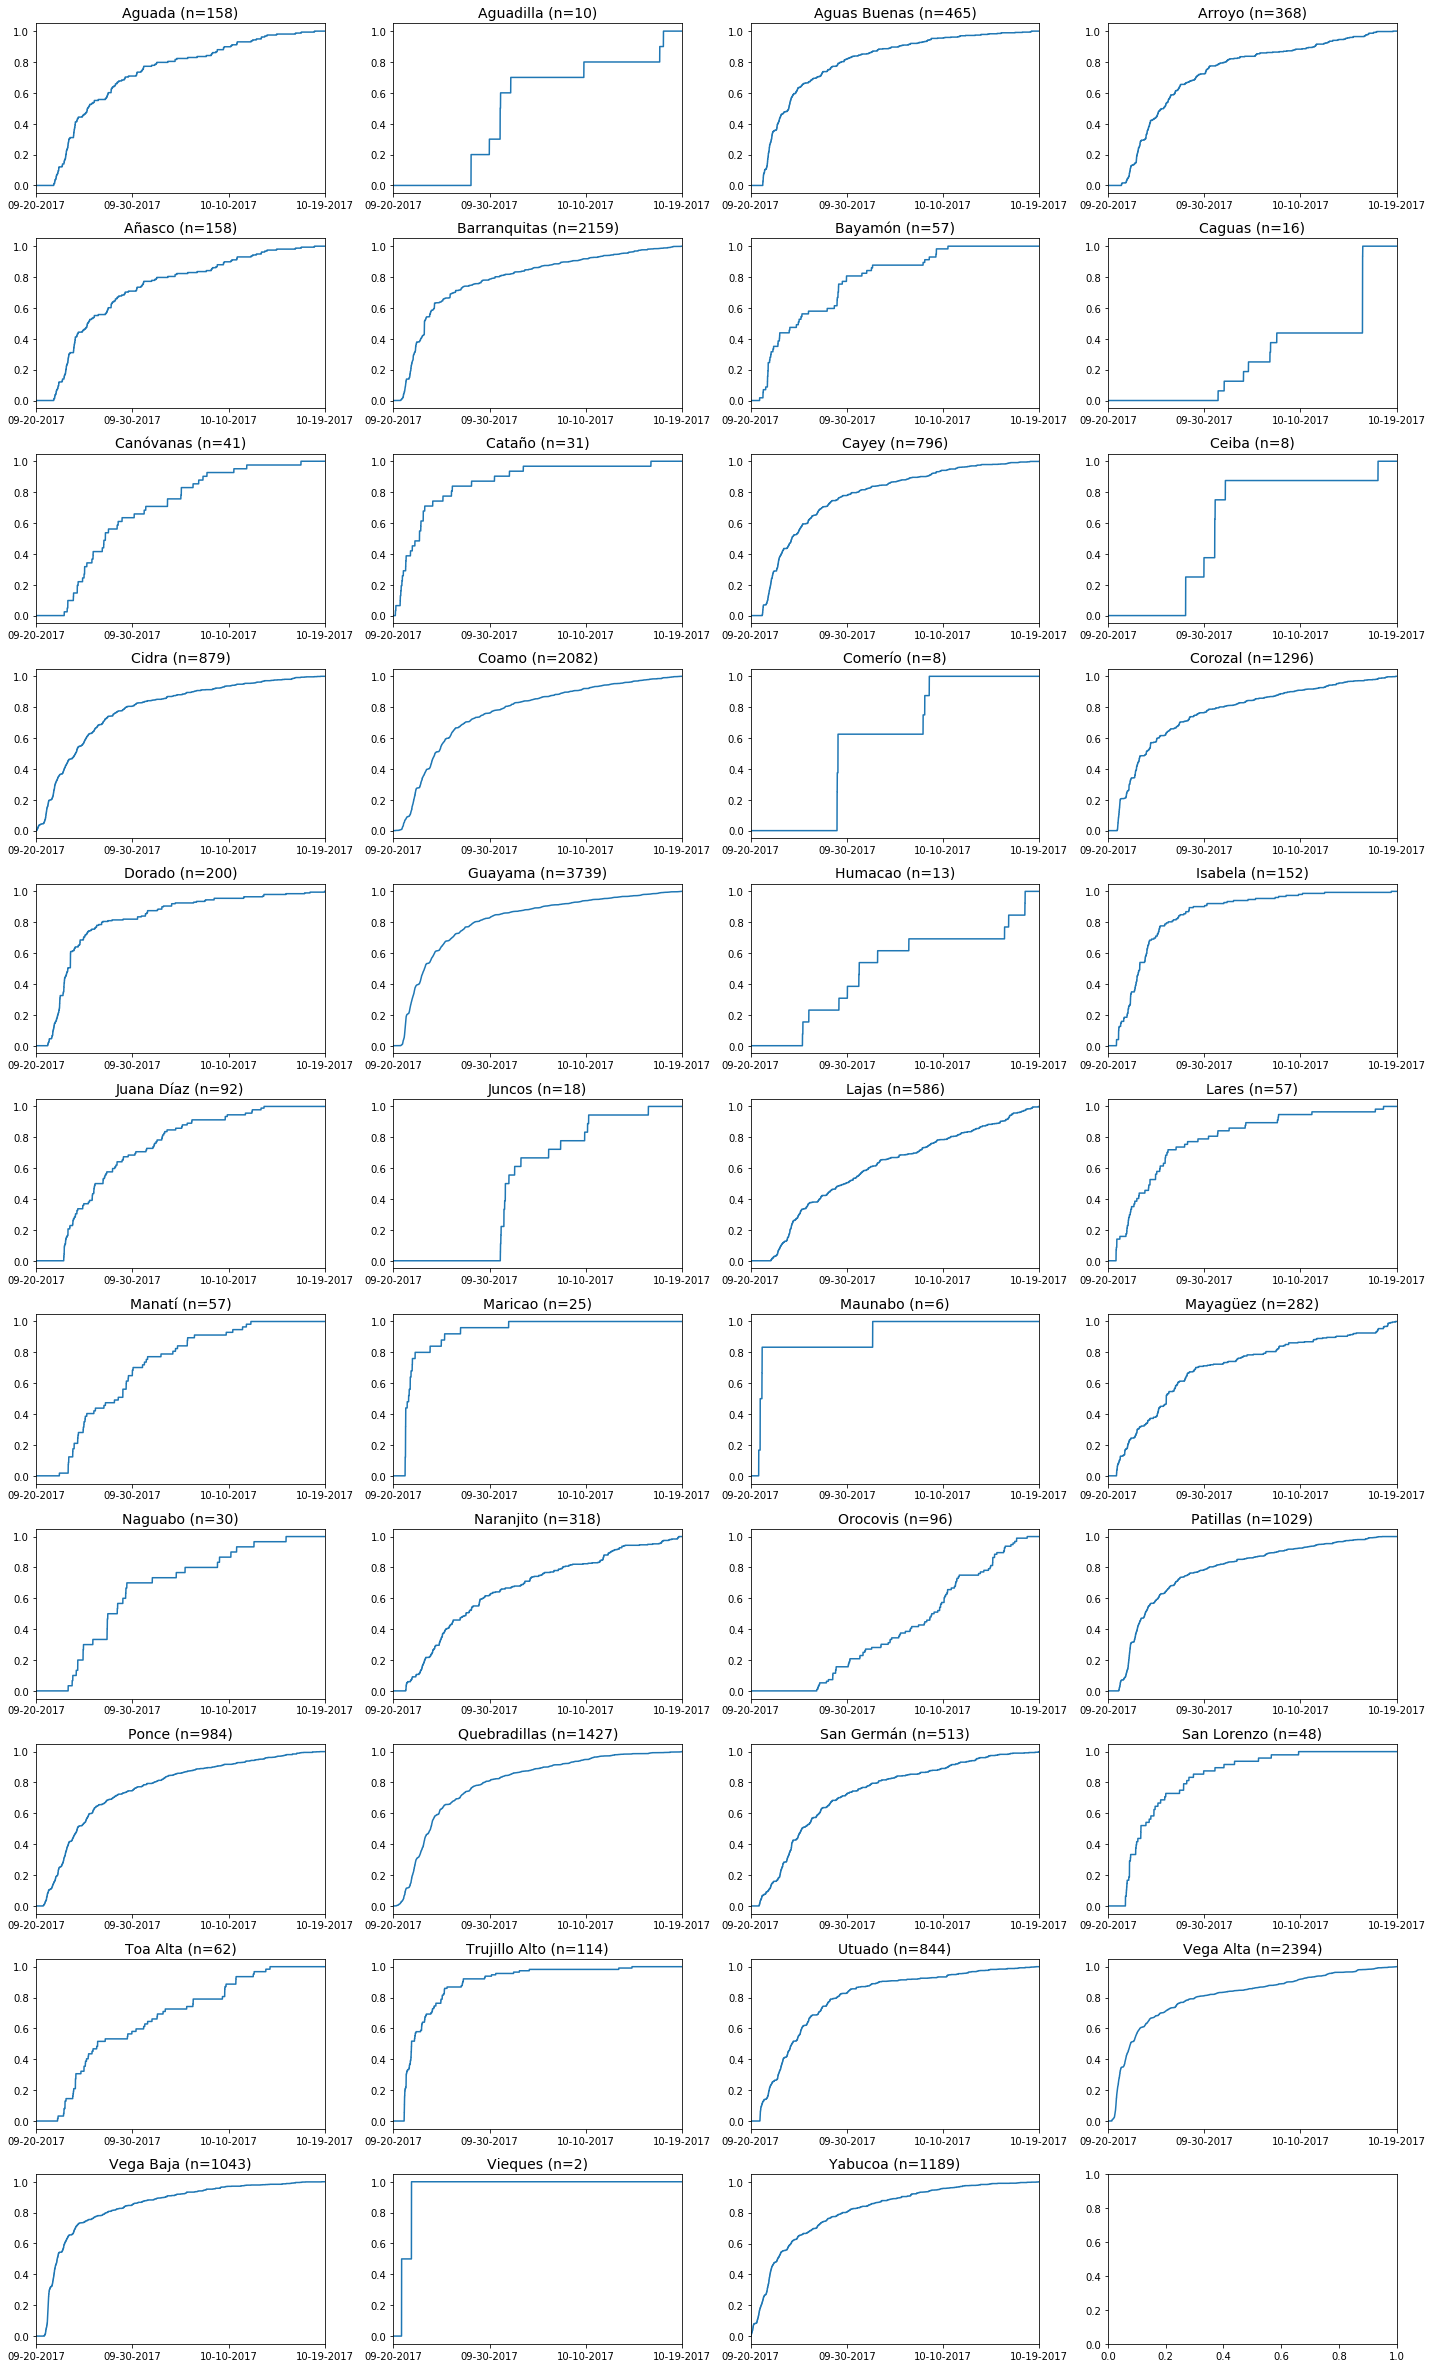

In [224]:
from __future__ import division
from math import ceil
G = fb_data_es.loc[:, 'location_name'].nunique()
start_time = fb_data_es.loc[:, 'status_published_min'].min()
end_time = fb_data_es.loc[:, 'status_published_min'].max()
date_fmt = '%m-%d-%Y'
cols = 4
rows = int(ceil(G / cols))
width = 5
height = 3
x_tick_count = 3
title_size = 14
x_ticks = np.linspace(convert_time(start_time), convert_time(end_time), x_tick_count+1)
x_tick_timestamps = map(lambda x: pd.Timestamp(x).strftime(date_fmt), x_ticks)
f, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*height))
for i, (group_loc, group_data) in enumerate(fb_data_es.groupby('location_name')):
    ax = axs[int(i / cols), i % cols]
    ## get cumulative time percent
    time_counts = group_data.loc[:, 'status_published_min'].value_counts()
    time_counts = time_counts.loc[time_counts.index.sort_values()]
    time_cumulative_pcts = time_counts.cumsum() / time_counts.sum()
    time_full = pd.date_range(start_time, end_time, freq='min')
    # start with empty time series, then fill with cumulative percents
    time_full_pcts = pd.Series(pd.np.zeros(len(time_full)), index=time_full)
    time_full_pcts.loc[time_cumulative_pcts.index] = time_cumulative_pcts.values
    # fill up the zeroes
    time_full_pcts = time_full_pcts.replace(to_replace=0, method='ffill')
    ## actually plot
    ax.plot(time_full_pcts.index, time_full_pcts)
    # replace xticks
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_timestamps)
    # fix title
    group_title = '%s (n=%d)'%(group_loc, group_data.shape[0])
    ax.set_title(group_title, fontsize=title_size)
plt.tight_layout()

It looks like the overall time trend holds across groups: the bulk of posts were sent in the first week, and then tapered off.

## Test sample
We sampled posts within 3x3 bins (High/Medium/Low x Early/Mid/Late), so let's see the group location count to make sure there's a decent balance.

In [229]:
sample_post_file = '../../data/facebook-maria/volume_time_binned_post_sample.tsv'
sample_posts = pd.read_csv(sample_post_file, sep='\t', index_col=False, encoding='utf-8')
sample_posts.head()

,group_id,status_author_id,status_message,status_lang,status_id,status_published,location_name,group_bin,time_bin
0,117445378946554,1.021240e+16,GENTE !!! CHEQUEEN SI LOS CONOCEN,es,117445378946554_117698898921202,2017-09-22 13:53:25,Utuado,Low,Early
1,117445378946554,1.499756e+15,"Mi familia, Perez Mendez , Andujar Figueroa, s...",es,117445378946554_117529055604853,2017-09-21 20:55:09,Utuado,Low,Early
2,142680509678003,1.015510e+16,Aparentemente la Urb. Punto Oro no está tan mal.,es,142680509678003_142810346331686,2017-09-21 21:53:48,Ponce,Low,Early
3,185336475344755,1.021034e+16,Segun acabo d escuchar en el app Zello lo q es...,es,185336475344755_185385195339883,2017-09-21 17:21:16,Mayagüez,Low,Early
4,1815374475420954,1.021395e+16,#Rabanal tiene acceso por la vía principal,es,1815374475420954_1815894755368926,2017-09-22 10:21:09,Cidra,Low,Early


In [230]:
sample_posts.loc[:, 'location_name'].value_counts()

Guayama          151
Vega Alta        100
Coamo             93
Barranquitas      83
Yabucoa           57
Quebradillas      57
Corozal           53
Vega Baja         41
Ponce             39
Cayey             38
Cidra             38
Utuado            35
Patillas          32
Arroyo            23
Aguas Buenas      21
San Germán        19
Lajas             17
Naranjito         16
Mayagüez          15
Añasco            12
Dorado            11
Aguada             8
Isabela            6
Lares              5
Trujillo Alto      4
Bayamón            4
Maricao            3
Cataño             3
Canóvanas          3
Juncos             2
Naguabo            2
Juana Díaz         2
Orocovis           2
Manatí             2
Toa Alta           1
San Lorenzo        1
Comerío            1
Name: location_name, dtype: int64